In [2]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg

SEED=0
np.random.seed(SEED)

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


In [12]:
forecasting_horizon = 168

nb_windows = 15
step_size = 191

lags = [2, 12, 23, 24, 36, 71, 72, 167, 168]
date_features = ["hour", "day", "day_of_week"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/hourly/"

In [13]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index)
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

## Prepandemic

In [51]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2018-10-01 00:00", end_index="2019-03-31 23:59", date_features=date_features)
print(initial_window_length)

1526


Model: KNeighborsRegressor
MASEs: [0.8529833782941422, 1.1880402995850432, 1.2686091406449802, 0.9677846484611814, 1.005353466338708, 1.489950303892705, 1.4776858405004196, 1.6169408653877406, 3.00201365817764, 2.5191898418787857, 2.5085410414365135, 2.7115135344285557, 2.5553176846100216, 1.2958606642035884, 1.0701334566381184]
MAEs: [2.202614285714286, 3.006785714285712, 3.10235119047619, 2.3320952380952376, 2.3413928571428566, 3.4225357142857136, 3.404309523809524, 3.693083333333333, 6.911457482993198, 5.867640306122449, 5.920809523809523, 6.322821428571429, 5.887839899848828, 2.982619047619048, 2.4472499999999995]
Fit time: 0.5343902111053467

Model: RandomForestRegressor
MASEs: [1.0299844967766425, 1.1406555291599498, 0.9586963173133871, 0.7085422678216013, 0.8938784466004671, 1.1096414514849842, 0.7358313477061541, 1.2212424905204275, 2.48340320525483, 1.8664460824143767, 1.4691383782733314, 0.8527885101111901, 1.345053641585806, 1.2144238296109997, 0.9106492321055026]
MAEs: [2.6

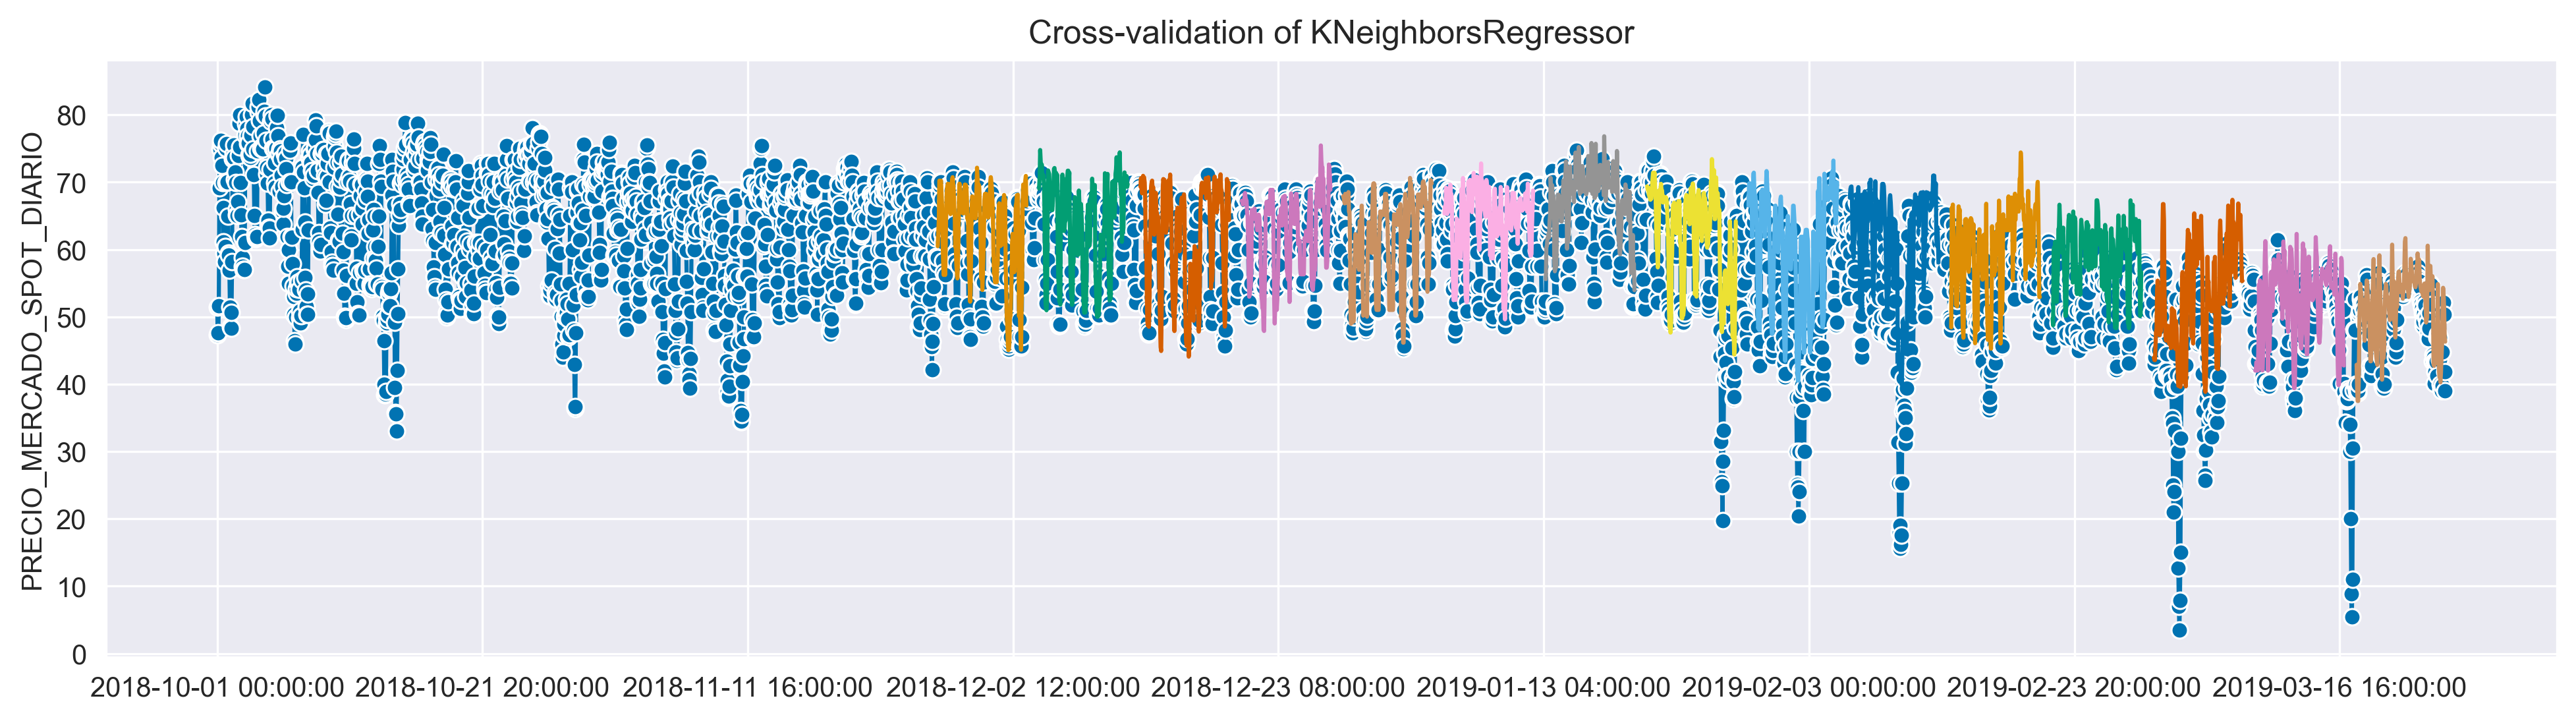

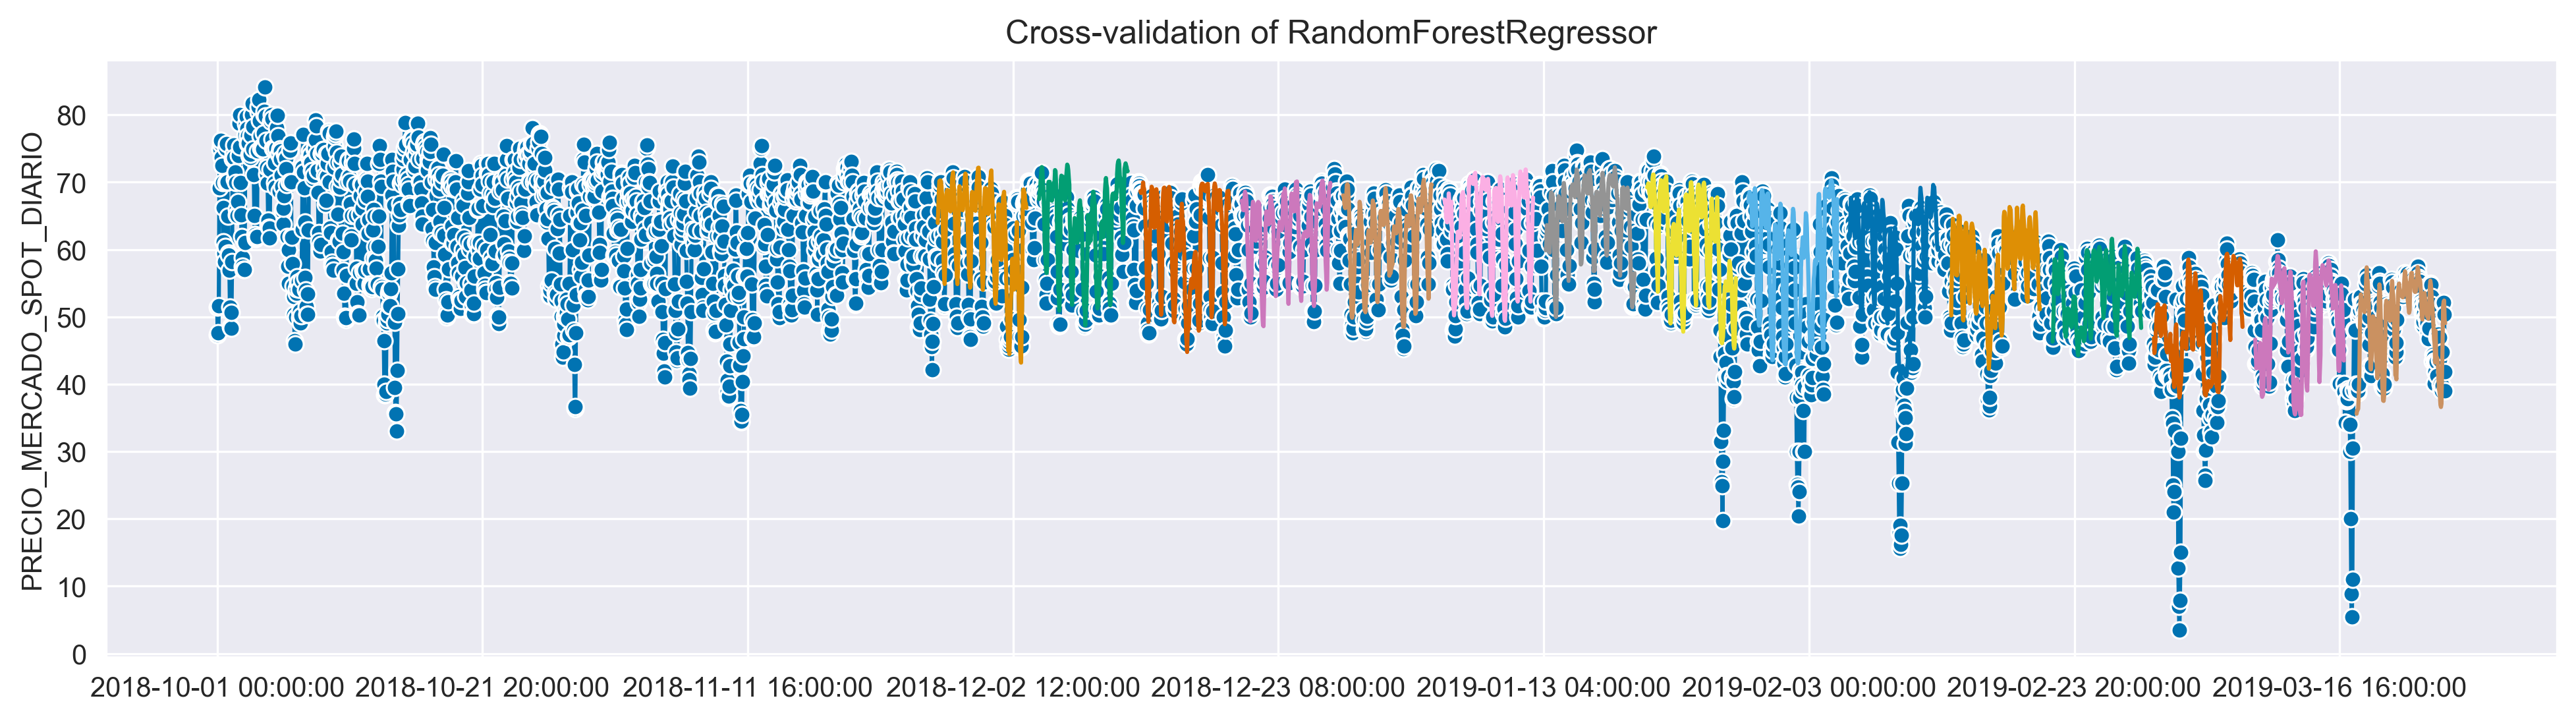

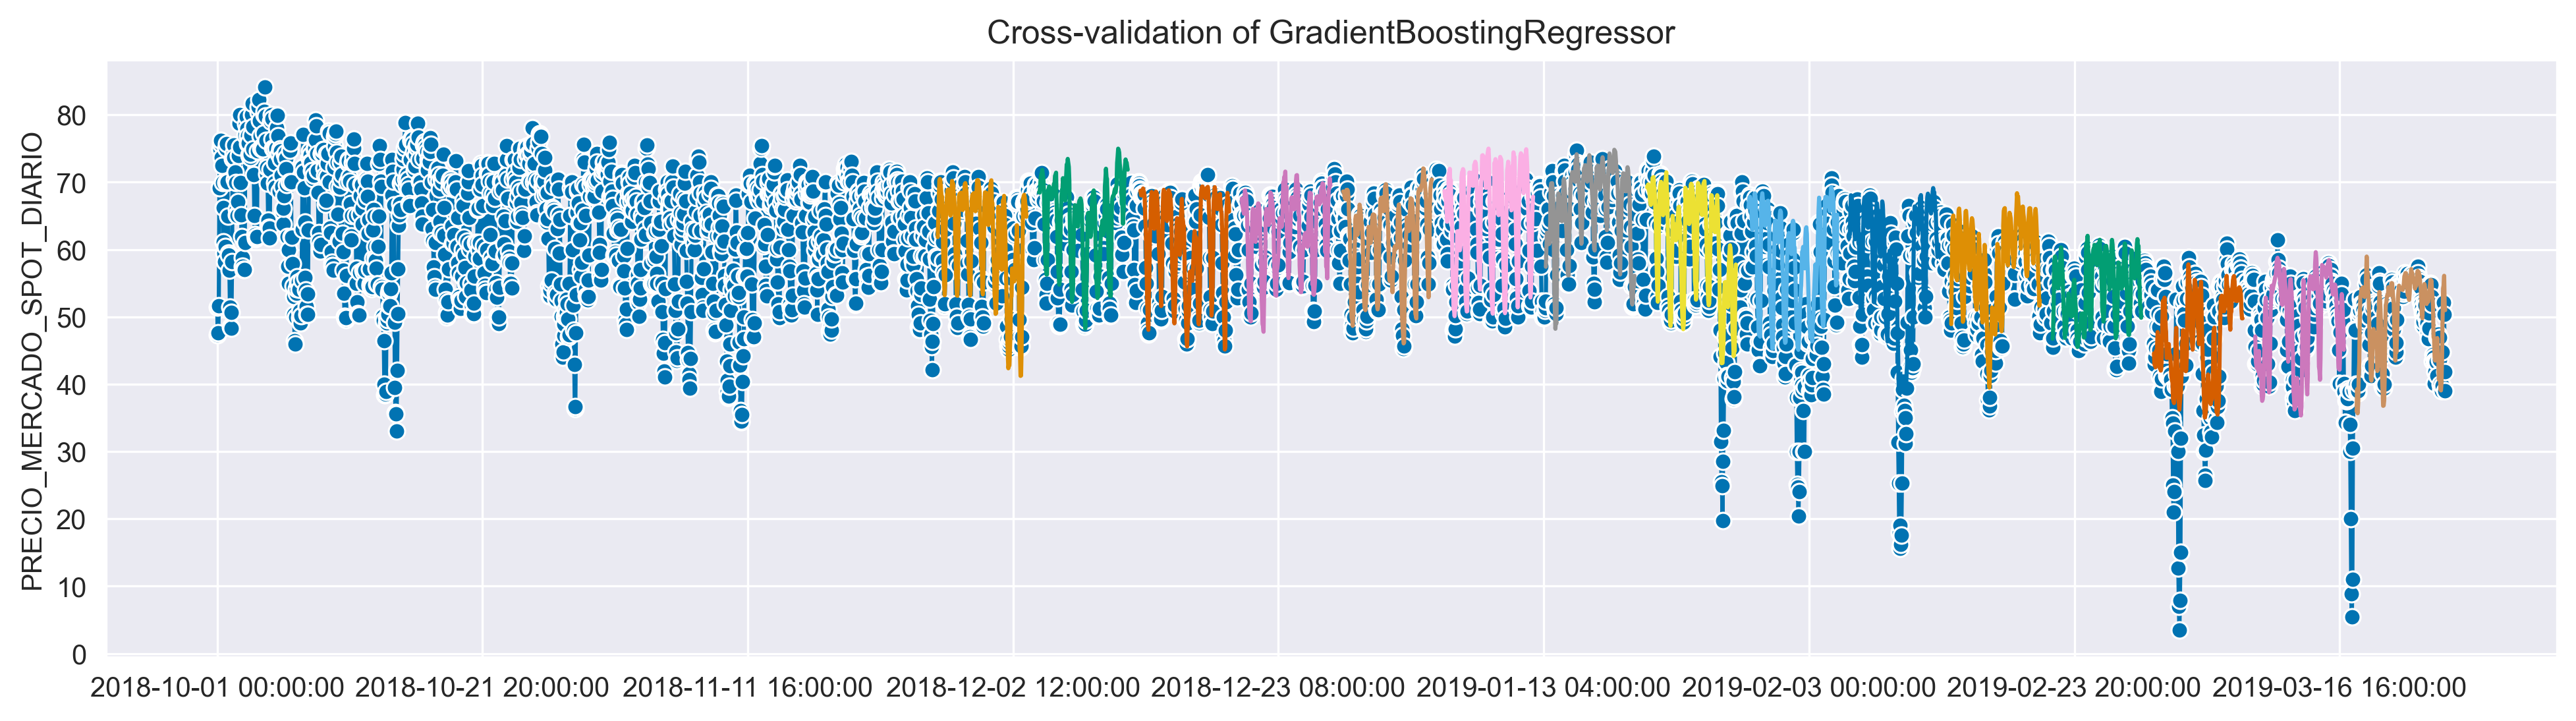

In [16]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [17]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase  mean_mae   fit_time
1      RandomForestRegressor   1.196025  2.814095  11.611818
2  GradientBoostingRegressor   1.264476  2.971196  17.635859
0        KNeighborsRegressor   1.701995  3.989707   0.534390

In [18]:
save_name="hourly_pre.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [52]:
save_name="hourly_pre.pkl"
cv_results_df = pd.read_pickle(save_path+save_name)

### Final model

In [53]:
data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test, columns=[column for column in data_train.columns if column not in date_features])

In [54]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
                 regressor     = best_model,
                 lags          = lags
             )

forecaster.fit(
    y       = data_train_iso.iloc[:, 0],
    exog    = data_train_iso.iloc[:, 1:],
)

In [55]:
y_pred = forecaster.predict(
    steps   = forecasting_horizon,
    exog    = data_test_iso.iloc[:, 1:]
)

y_pred = pd.Series(data=y_pred, index=data_test_iso.iloc[:, 0].index)

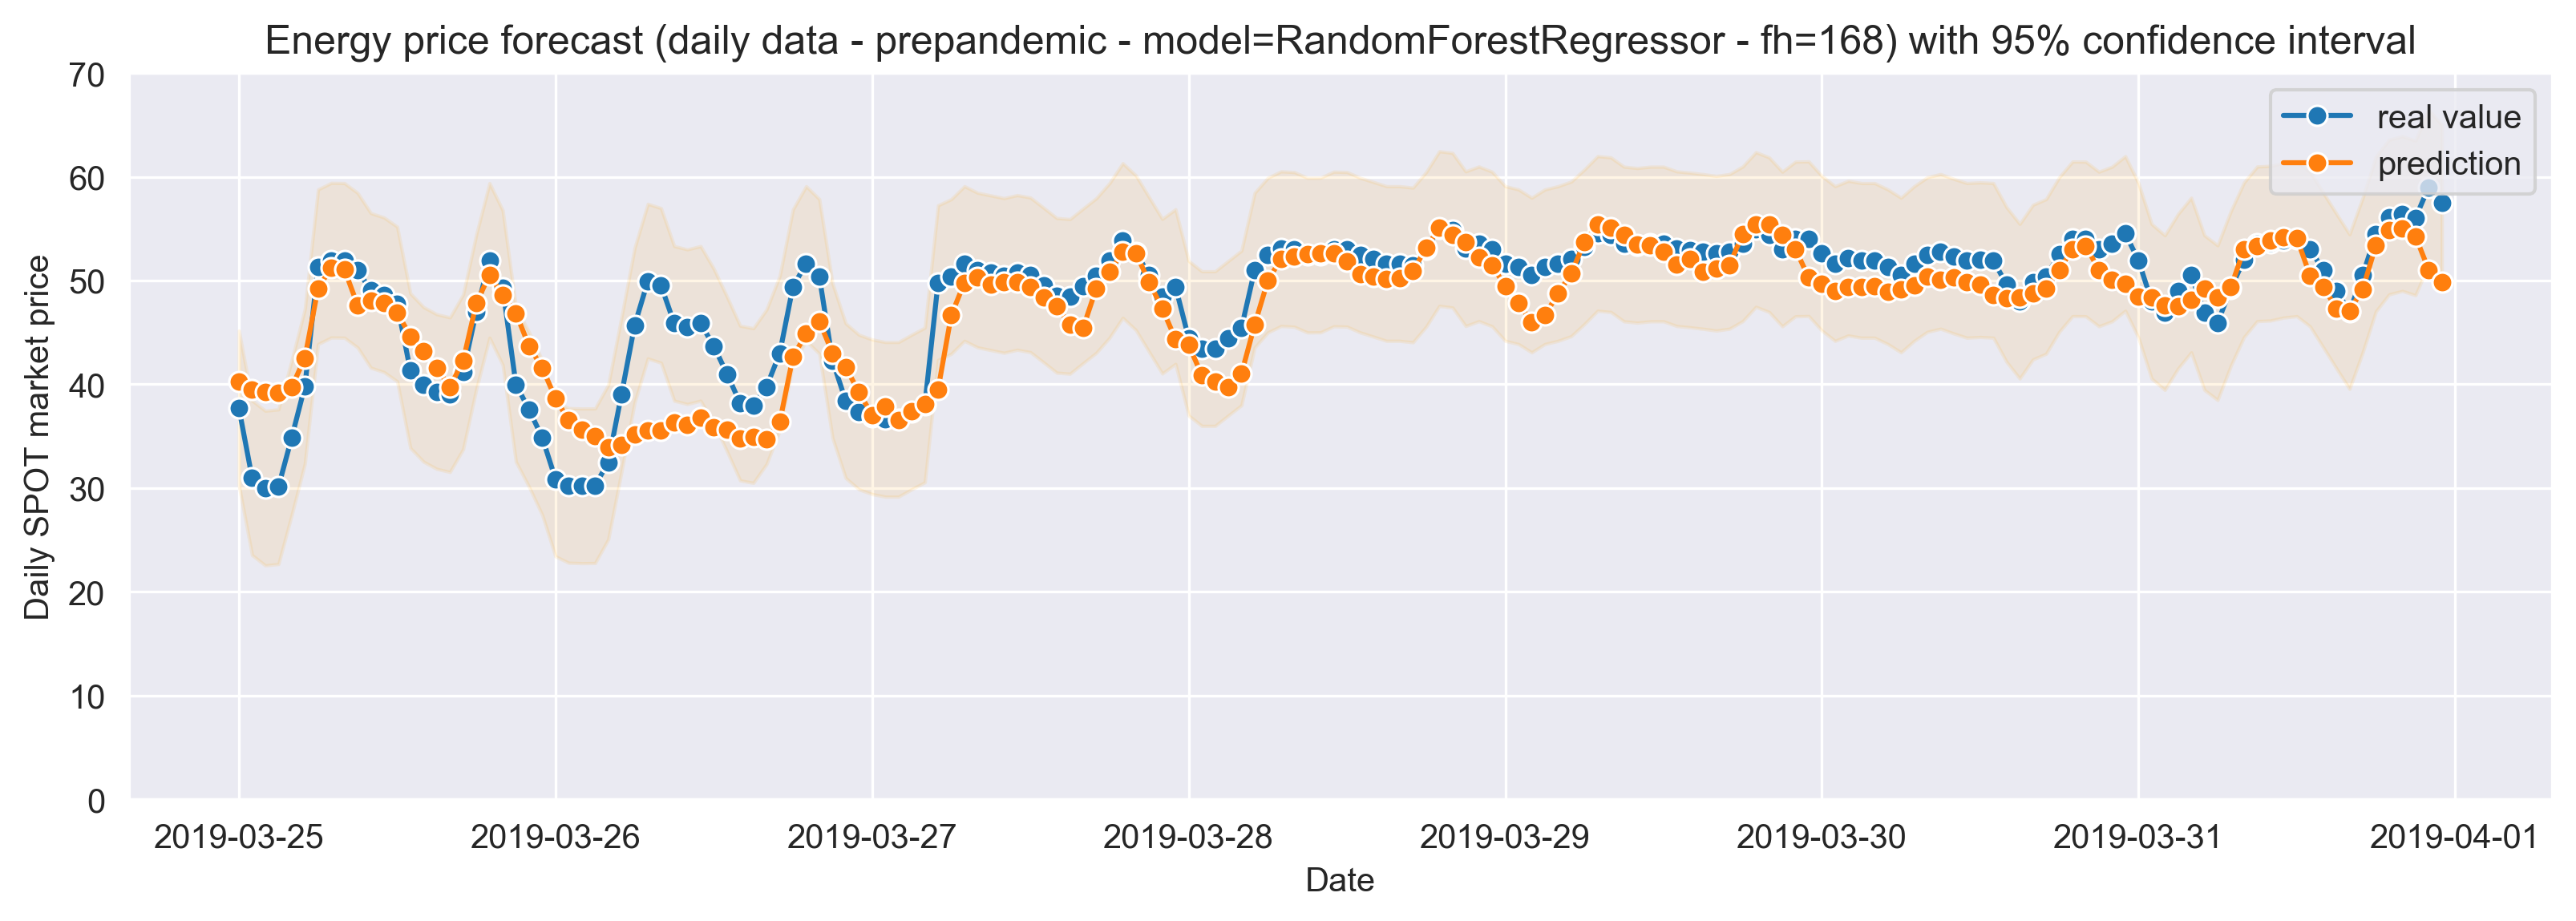

In [56]:
residuals = abs(y_pred-data_test_iso.iloc[:, 0])
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(data_test_iso.iloc[:, 0].index) is pd.core.indexes.period.PeriodIndex:
    data_test_iso.iloc[:, 0].index = data_test_iso.iloc[:, 0].index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13,4))
sns.lineplot(data=data_test_iso.iloc[:, 0], palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(data_test_iso.iloc[:, 0].index, (data_test_iso.iloc[:, 0]-band_size), (data_test_iso.iloc[:, 0]+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0,70])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()

## Postpandemic

In [48]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2022-10-01 00:00", end_index="2023-03-31 23:59", date_features=date_features)
print(initial_window_length)

1526


Model: KNeighborsRegressor
MASEs: [1.6585795733212458, 2.197535048529973, 2.1147598282530895, 4.392270542508152, 2.551384323882864, 3.0063902766490567, 3.3826449640961664, 1.910321854332634, 3.406527544864979, 1.648687537886696, 1.1746541843024745, 2.3007972545859263, 2.1746326600534345, 2.600580719907994, 2.0708337620334727]
MAEs: [19.807119047619047, 25.177988095238096, 23.587780612244895, 48.74876388888889, 27.661023809523808, 31.290476190476188, 35.206630952380955, 19.59988095238095, 35.15116071428571, 17.151871031746033, 11.934011904761904, 22.98517083333333, 21.567695634920636, 25.521083333333337, 20.55717857142857]
Fit time: 0.474628210067749

Model: RandomForestRegressor
MASEs: [2.5362430607057718, 2.7850792414854864, 1.652145751064578, 3.065864915085525, 2.0769097465330835, 2.5791840369951706, 2.149951995508235, 1.8507884076507655, 2.2060297608743626, 1.2576444770602981, 0.7452797337939948, 1.285761293335755, 1.2789994540836356, 2.214112553699002, 1.752096255337301]
MAEs: [30.

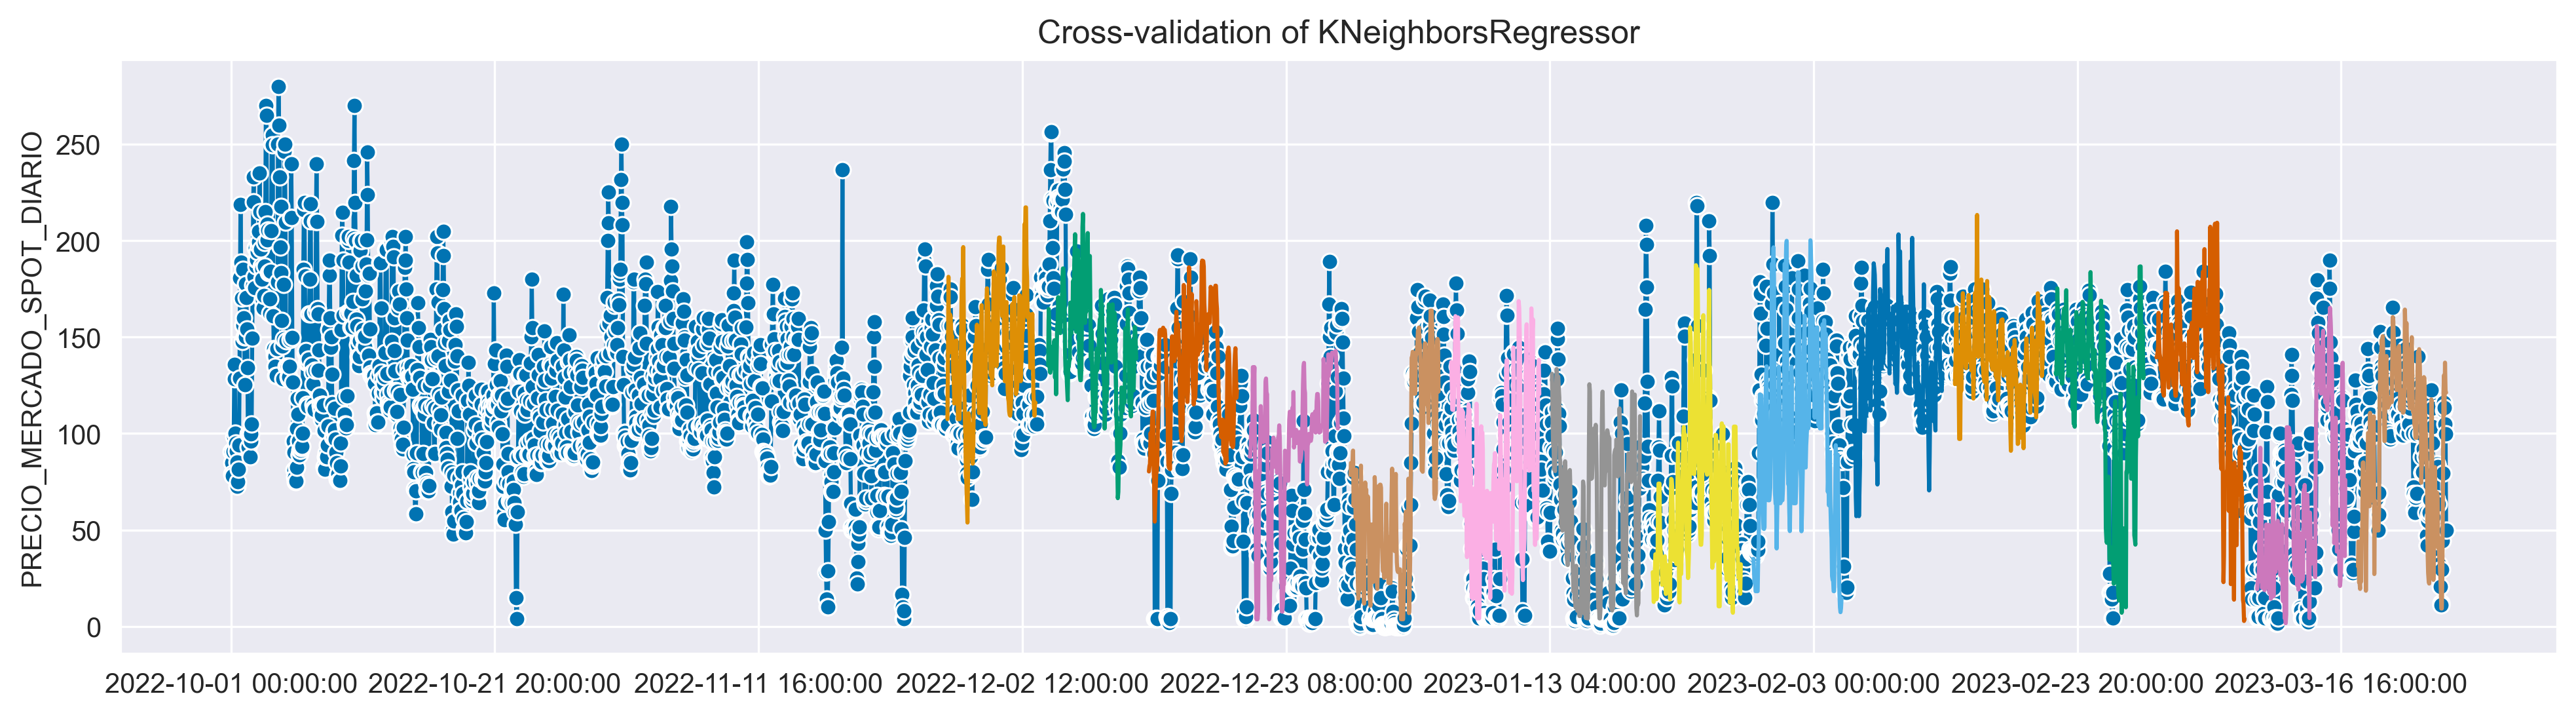

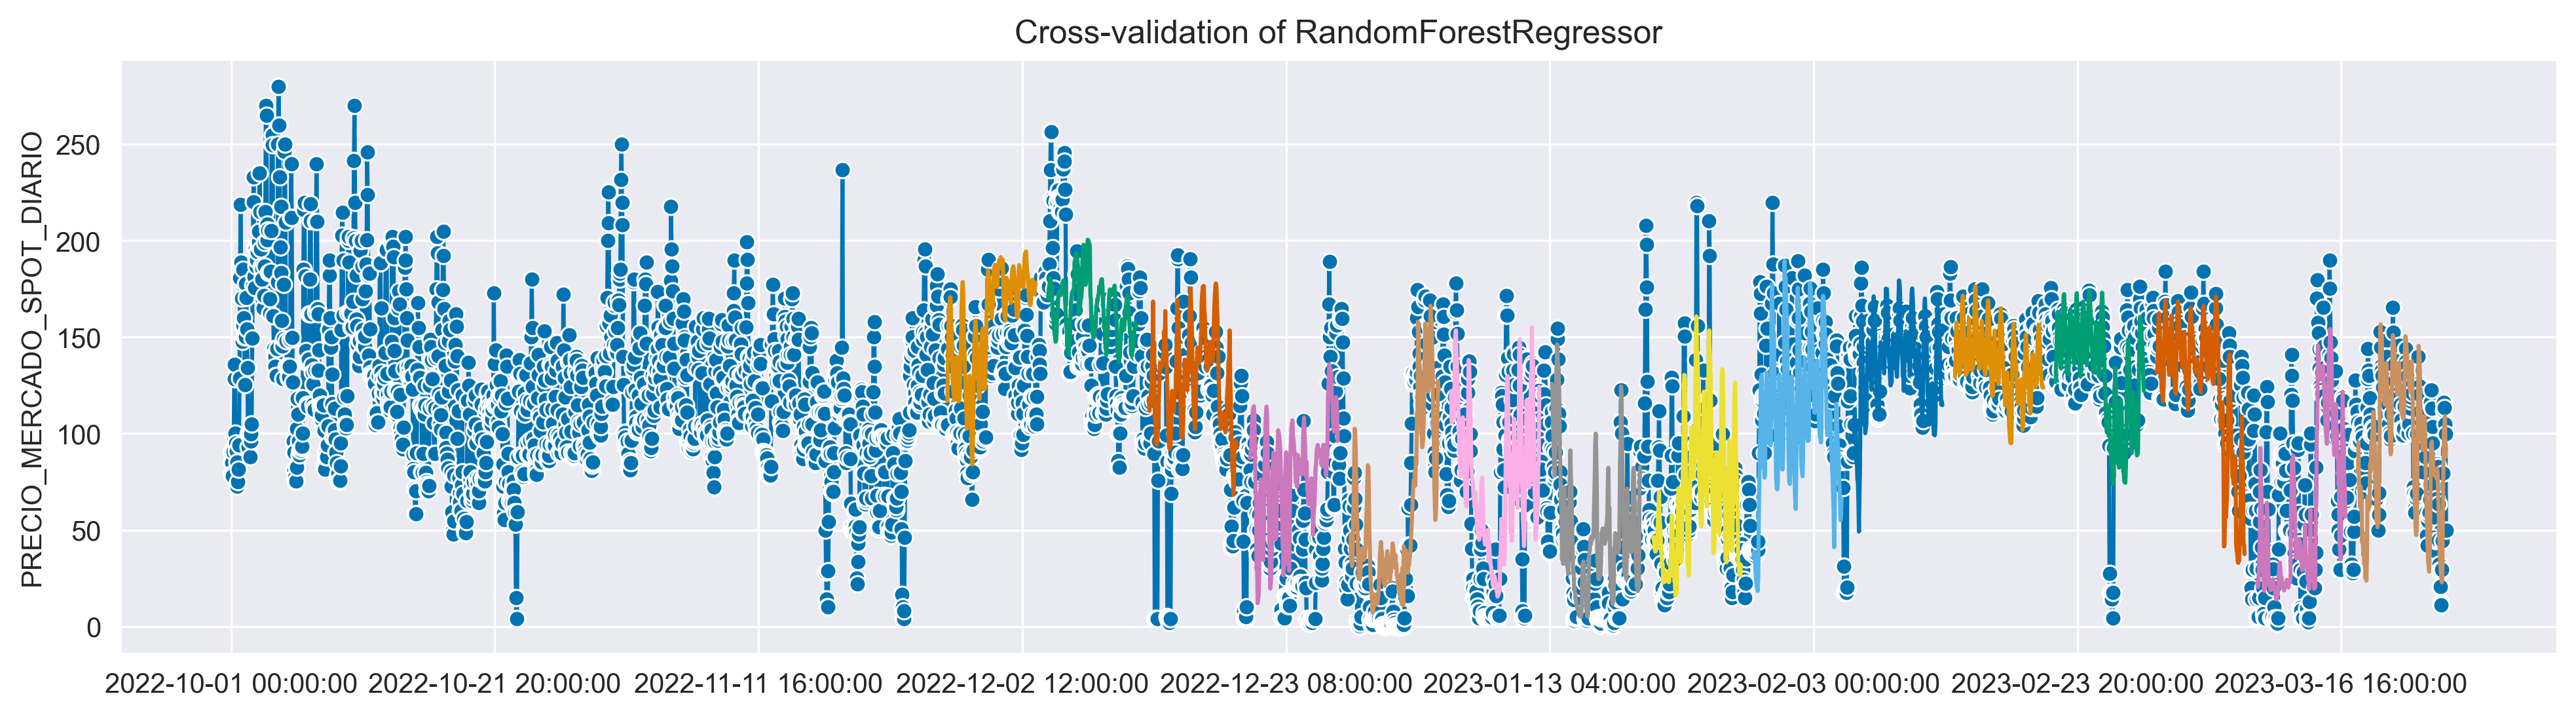

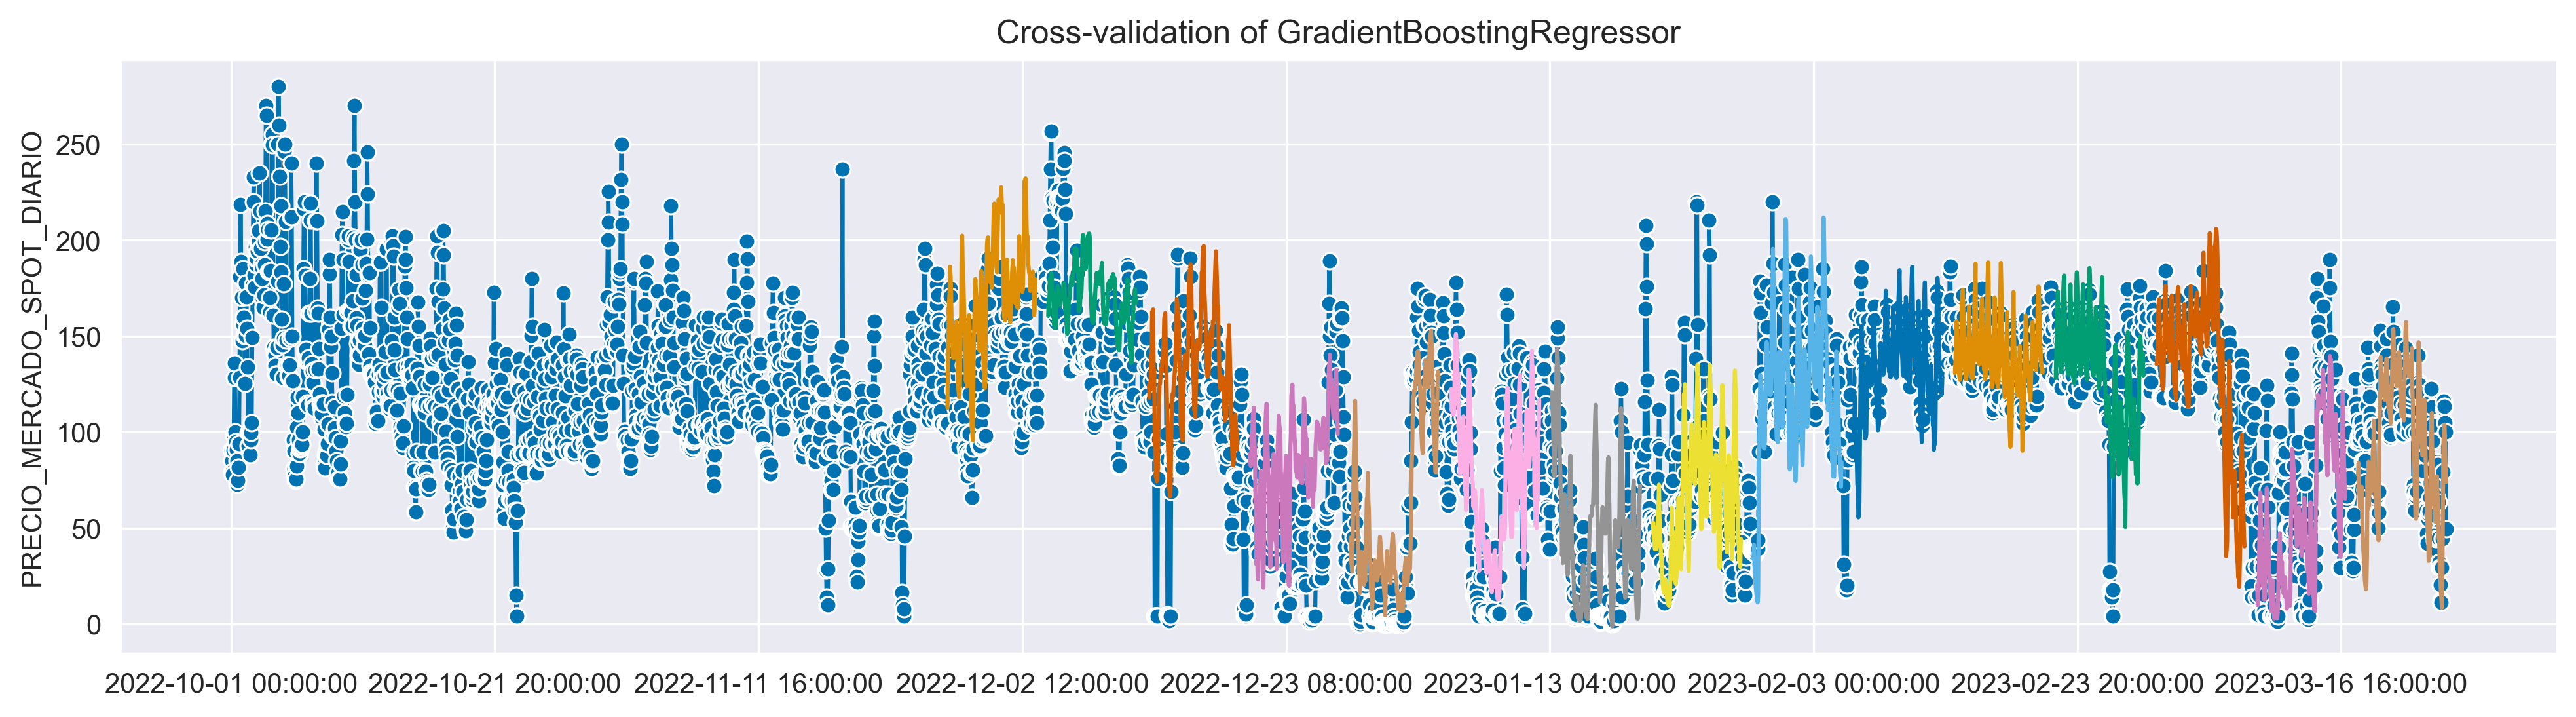

In [25]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [26]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

model  mean_mase   mean_mae   fit_time
1      RandomForestRegressor   1.962406  20.896692   9.702910
2  GradientBoostingRegressor   2.081246  22.254823  17.692391
0        KNeighborsRegressor   2.439373  25.729856   0.474628

In [27]:
save_name="hourly_post.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [49]:
save_name="hourly_post.pkl"
cv_results_df = pd.read_pickle(save_path+save_name)

### Final model

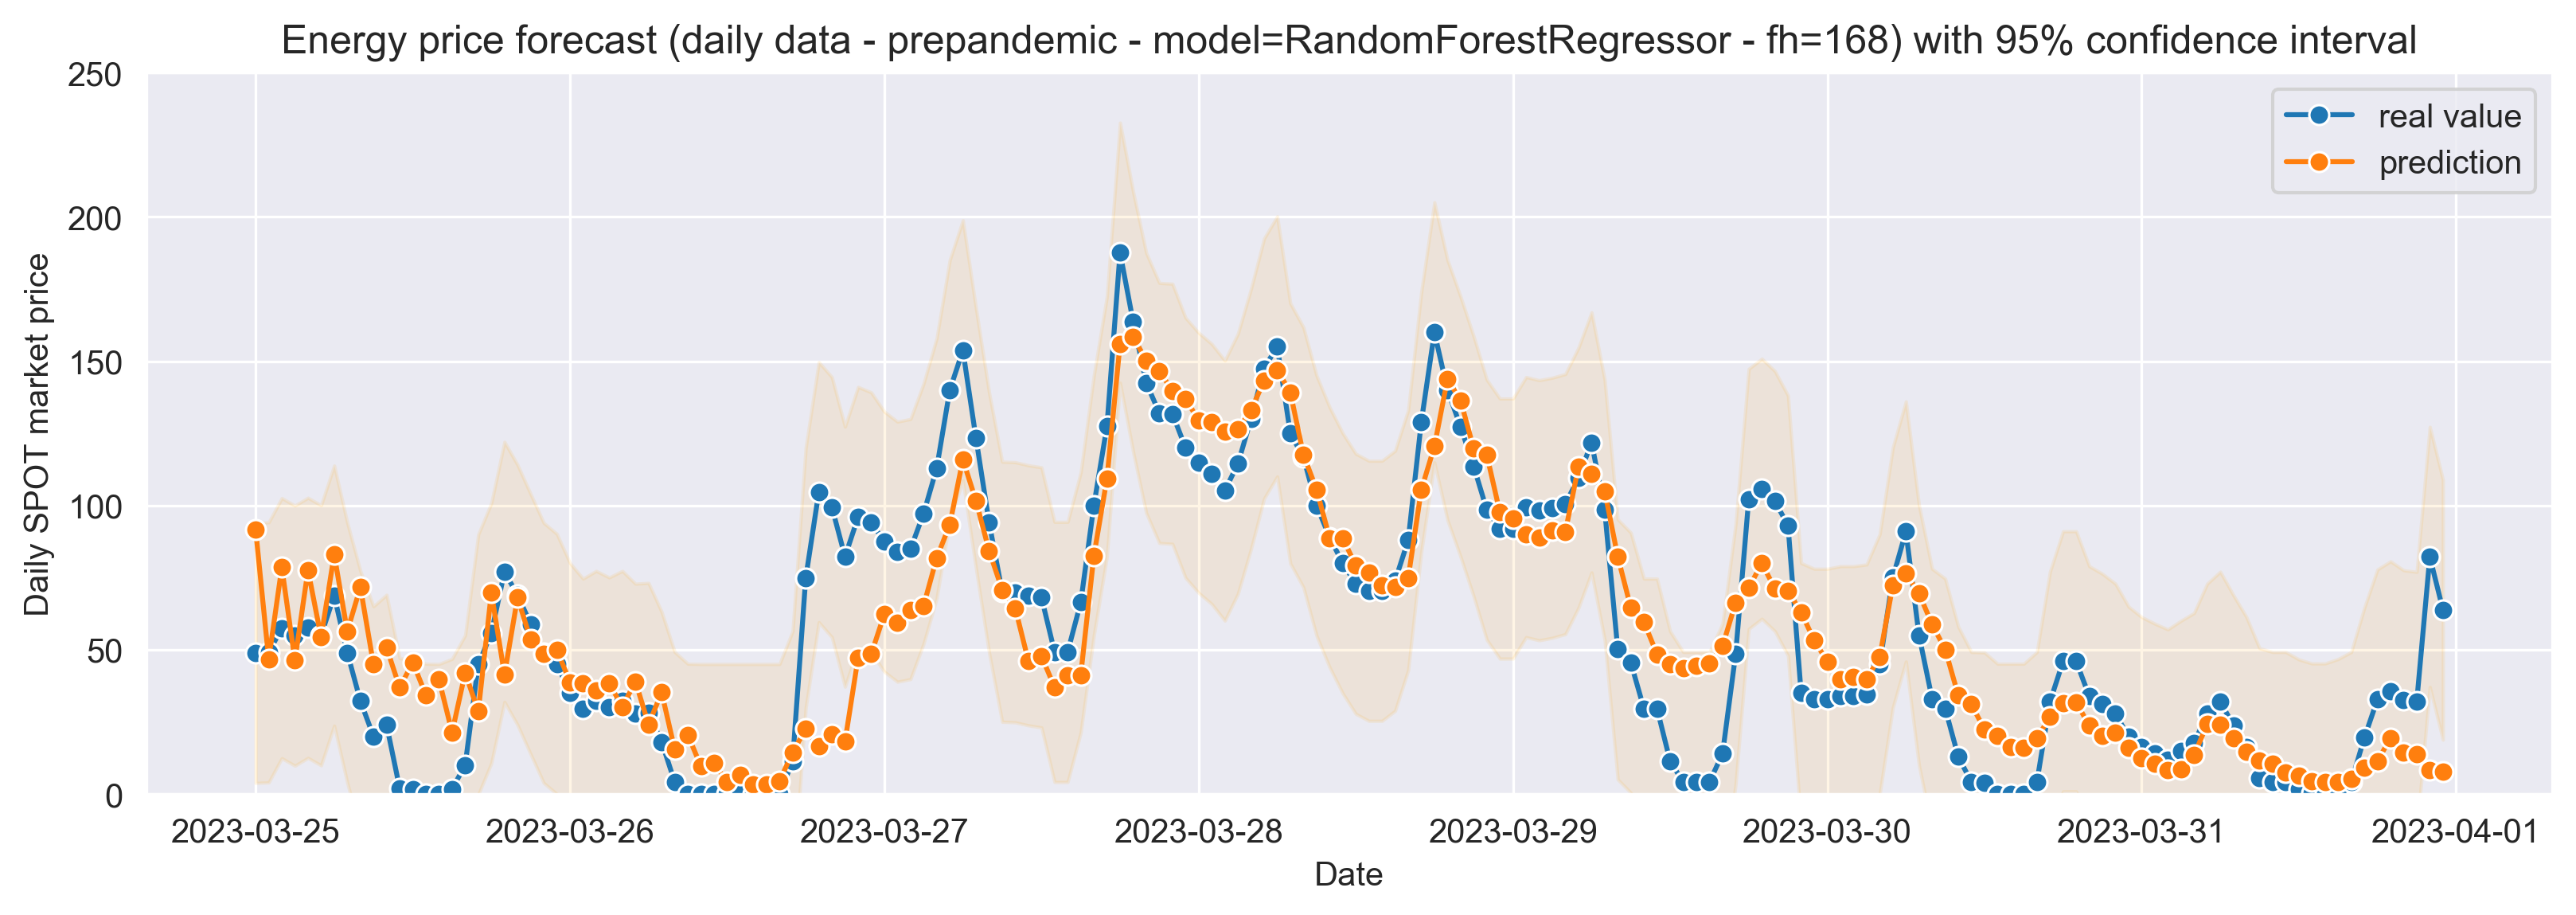

In [50]:
data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test,
                                                                             columns=[column for column in
                                                                                      data_train.columns if
                                                                                      column not in date_features])
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = ForecasterAutoreg(
    regressor=best_model,
    lags=lags
)

forecaster.fit(
    y=data_train_iso.iloc[:, 0],
    exog=data_train_iso.iloc[:, 1:],
)
y_pred = forecaster.predict(
    steps=forecasting_horizon,
    exog=data_test_iso.iloc[:, 1:]
)

y_pred = pd.Series(data=y_pred, index=data_test_iso.iloc[:, 0].index)
residuals = abs(y_pred - data_test_iso.iloc[:, 0])
RMSFE = np.sqrt(sum([x ** 2 for x in residuals]) / len(residuals))
band_size = 1.96 * RMSFE

if type(data_test_iso.iloc[:, 0].index) is pd.core.indexes.period.PeriodIndex:
    data_test_iso.iloc[:, 0].index = data_test_iso.iloc[:, 0].index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(13, 4))
sns.lineplot(data=data_test_iso.iloc[:, 0], palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(data_test_iso.iloc[:, 0].index, (data_test_iso.iloc[:, 0] - band_size),
                (data_test_iso.iloc[:, 0] + band_size), color='orange', alpha=.1)
ax.set_title(
    f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
ax.set_ylim([0, 250])
ax.legend(loc="upper right", labels=["real value", "prediction"])
plt.show()